In [1]:
import numpy as np
import random
import cv2
import math
import copy
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# img = Image.open("images/000000000785.jpg")
# img = img.convert("RGB")                   # 图片转为RGB格式
# img = np.array(img)

img = cv2.imread('images/000000000785.jpg', cv2.IMREAD_COLOR)

height = img.shape[0]
width = img.shape[1]
print("img_shape: ", img.shape)
print("height: ", height)
print("width: ", width)

img_show = copy.deepcopy(img)
labels = []
with open('./images/000000000785.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        cls, x, y, w, h = map(float, line.split())
        x1 = int((x - w / 2) * width)
        y1 = int((y - h / 2) * height)
        x2 = int((x + w / 2) * width)
        y2 = int((y + h / 2) * height)
        labels.append([x1, y1, x2, y2])

        img_label = cv2.rectangle(img_show, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)

img_shape:  (425, 640, 3)
height:  425
width:  640


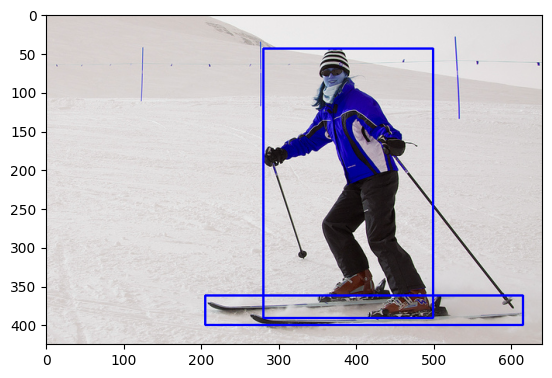

In [3]:
%matplotlib inline

plt.imshow(img_label)
plt.show()

# 上下翻转

In [4]:
img_flipud = np.ascontiguousarray(np.flipud(copy.deepcopy(img)))

for label in labels:
    x1, y1, x2, y2 = label
    y1 = height - y1
    y2 = height - y2
    img_flipud_label = cv2.rectangle(img_flipud, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)
    

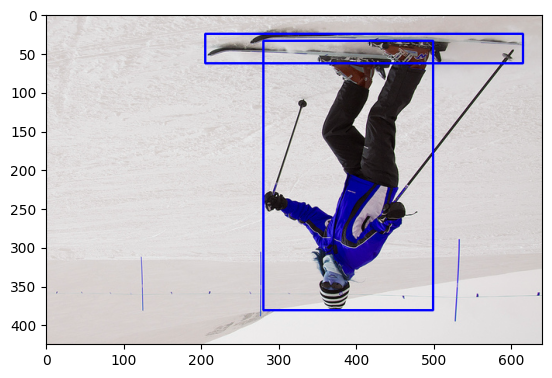

In [5]:
%matplotlib inline

plt.imshow(img_flipud_label) 
plt.show()

# 左右翻转

In [6]:
img_fliplr = np.ascontiguousarray(np.fliplr(copy.deepcopy(img)))

for label in labels:
    x1, y1, x2, y2 = label
    x1 = width - x1
    x2 = width - x2
    img_fliplr_label = cv2.rectangle(img_fliplr, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)
    

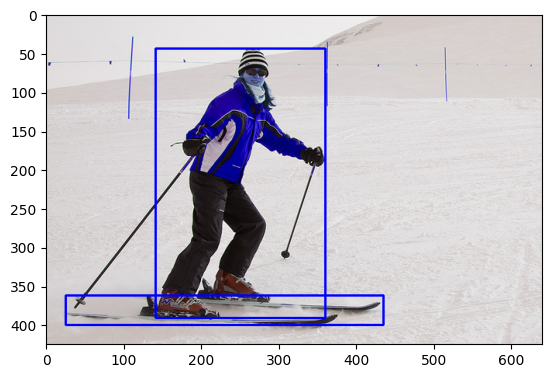

In [7]:
%matplotlib inline

plt.imshow(img_fliplr_label) 
plt.show()

# Perspective

In [8]:
sheer = 0.1
translate = 0.1
scale = 0.1
degree = 0
perspective = 0.0001

In [9]:
C = np.eye(3, dtype=np.float32)

In [10]:
C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
C[1, 2] = -img.shape[0] / 2  # y translation (pixels)
print(C)

[[   1.     0.  -320. ]
 [   0.     1.  -212.5]
 [   0.     0.     1. ]]


In [11]:
P = np.eye(3, dtype=np.float32)
P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
P[2, 1] = random.uniform(-perspective, perspective)
print(P)

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [-9.2593757e-05  6.0441536e-05  1.0000000e+00]]


In [12]:
R = np.eye(3, dtype=np.float32)
a = random.uniform(-degree, degree)
print('a:', a)
# a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
s = random.uniform(1 - scale, 1 + scale)
print("s:", s)
# s = 2 ** random.uniform(-scale, scale)
R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)
print(R)

a: 0.0
s: 0.9473165448062582
[[ 0.9473165  0.         0.       ]
 [-0.         0.9473165  0.       ]
 [ 0.         0.         1.       ]]


In [13]:
S = np.eye(3, dtype=np.float32)
S[0, 1] = math.tan(random.uniform(-sheer, sheer) * math.pi / 180)  # x shear (deg)
S[1, 0] = math.tan(random.uniform(-sheer, sheer) * math.pi / 180)  # y shear (deg)
print(S)

[[ 1.0000000e+00 -9.7367470e-04  0.0000000e+00]
 [ 1.1784061e-03  1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [14]:
T = np.eye(3, dtype=np.float32)
T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * img.shape[1]  # x translation (pixels)
T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * img.shape[0]  # y translation (pixels)
print(T)

[[  1.        0.      307.40247]
 [  0.        1.      199.5032 ]
 [  0.        0.        1.     ]]


In [15]:
M = T @ S @ R @ P @ C
print(M)

[[ 9.1885298e-01  1.7657500e-02  9.6172791e+00]
 [-1.7356427e-02  9.5937479e-01  1.1901245e+00]
 [-9.2593757e-05  6.0441536e-05  1.0167862e+00]]


In [16]:
img_perspective = np.ascontiguousarray(copy.deepcopy(img))
if perspective:    
    img_perspective = cv2.warpPerspective(img_perspective, M, dsize=(img.shape[1], img.shape[0]), borderValue=(114, 114, 114))
else:  # affine
    img_perspective = cv2.warpAffine(img_perspective, M[:2], dsize=(img.shape[1], img.shape[0]), borderValue=(114, 114, 114))

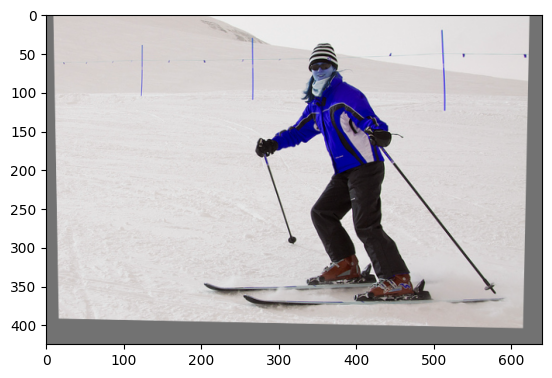

In [17]:
%matplotlib inline
 
# img = np.random.random((128,128,3))
plt.imshow(img_perspective)
plt.show()

In [18]:
n = len(labels)
labels = np.array(labels)
xy = np.ones((n * 4, 3))
xy[:, :2] = labels[:, [0, 1, 2, 3, 0, 3, 2, 1]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
xy = xy @ M.T  # transform
xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

# Create new boxes
x = xy[:, [0, 2, 4, 6]]
y = xy[:, [1, 3, 5, 7]]


In [19]:
print('x: ')
print(x)
print('y: ')
print(y)

x: 
[[269.41904363 477.79323841 269.88880497 481.79400035]
 [200.42884754 591.22400061 200.63496128 591.9237163 ]]
y: 
[[ 38.79422551 369.78416733 366.13954951  35.69695988]
 [338.26716544 380.34462847 373.17907987 344.09942399]]


In [20]:
labels_new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T
print(labels_new)

[[269.41904363  35.69695988 481.79400035 369.78416733]
 [200.42884754 338.26716544 591.9237163  380.34462847]]


In [21]:
for label in labels_new:
    label[0] = max(label[0], 0)
    label[1] = max(label[1], 0)
    label[2] = min(label[2], width)
    label[3] = min(label[3], height)

In [22]:
print(labels_new)

[[269.41904363  35.69695988 481.79400035 369.78416733]
 [200.42884754 338.26716544 591.9237163  380.34462847]]


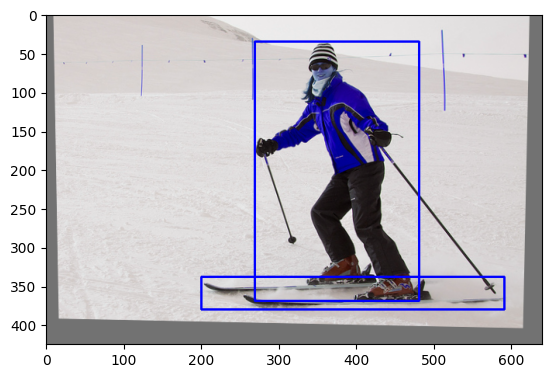

In [23]:
img_perspective = cv2.rectangle(img_perspective, (int(labels_new[0, 0]), int(labels_new[0, 1])), (int(labels_new[0, 2]), int(labels_new[0, 3])), color=(0, 0, 255), thickness=2)
img_perspective = cv2.rectangle(img_perspective, (int(labels_new[1, 0]), int(labels_new[1, 1])), (int(labels_new[1, 2]), int(labels_new[1, 3])), color=(0, 0, 255), thickness=2)

%matplotlib inline
plt.imshow(img_perspective)
plt.show()

In [24]:
# if rect_mode:  # resize long side to imgsz while maintaining aspect ratio
imgsz = 640
im = copy.deepcopy(img)
h0, w0 = im.shape[:2]  # orig hw
r = imgsz / max(h0, w0)  # ratio
if r != 1:  # if sizes are not equal
    w, h = (min(math.ceil(w0 * r), imgsz), min(math.ceil(h0 * r), imgsz))
    im = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)
    
im.shape

(425, 640, 3)

# 马赛克增强

In [28]:
# def _mosaic4(self, labels):
#     """Create a 2x2 image mosaic."""
mosaic_labels = []
s = (425, 640)
yc, xc = (int(random.uniform(-x, 2 * s[i] + x)) for i, x in enumerate((-425 // 2, -640 // 2)))  # mosaic center x, y
# print(yc, xc)
labels_mosaic = np.array(labels, dtype=np.int32)
result = copy.deepcopy(labels_mosaic)

# im_list = []
# for i, shape in enumerate([[425, 640], [640, 425], [640, 425], [425, 640]]):
#     im = cv2.resize(im, shape, interpolation=cv2.INTER_LINEAR)
#     im_list.append(im)
    
    
for i in range(4):

    h, w = 425, 640
    # img_origin = copy.deepcopy(img)

    # Place img in img4
    if i == 0:  # top left
        img4 = np.full((s[0] * 2, s[1] * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif i == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s[1] * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif i == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s[0] * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
    elif i == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s[1] * 2), min(s[0] * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
    # print(x1a, y1a, x2a, y2a)
    # print(x1b, y1b, x2b, y2b)
    img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
    padw = x1a - x1b
    padh = y1a - y1b
    # labels_patch = _update_labels(labels_patch, padw, padh)
    print(padw, padh)
    
    result[:, 0] = labels_mosaic[:, 0] + padw
    result[:, 1] = labels_mosaic[:, 1] + padh
    result[:, 2] = labels_mosaic[:, 2] + padw
    result[:, 3] = labels_mosaic[:, 3] + padh
    print(labels_mosaic)
    img4 = cv2.rectangle(img4, (int(result[1, 0]), int(result[1, 1])), (int(result[1, 2]), int(result[1, 3])), color=(0, 0, 255), thickness=2)
    plt.imshow(img4)
    plt.show()
    


-156 -157


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
print(labels_mosaic)

[[280  44 499 391]
 [205 362 615 400]]


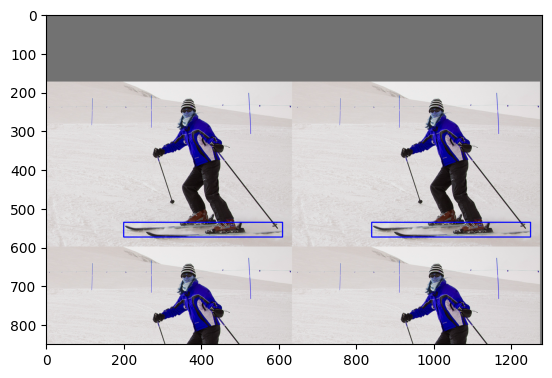

In [27]:
%matplotlib inline

plt.imshow(img4)
plt.show()